In [60]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch
from torch_tomogram_dataset.augmented_dataset_wrapper import AugmentedDatasetWrapper

# Custom collate function
def custom_collate_fn(batch):
    """
    Custom collate function to pad images in a batch to the same size.
    """
    images, labels = zip(*batch)

    # Find the max height and width in the batch
    max_height = max(img.shape[1] for img in images)
    max_width = max(img.shape[2] for img in images)

    # Pad images to the same size
    padded_images = []
    for img in images:
        _, h, w = img.shape
        padding = (0, max_width - w, 0, max_height - h)  # (left, right, top, bottom)
        pad_value = img.min().item()  # Get the minimum value of the image
        padded_images.append(F.pad(img, padding, value=pad_value))  # Pad with zeros

    return torch.stack(padded_images), torch.tensor(labels)

# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing 'apoptosis' and 'necrosis' folders.
            transform (callable, optional): Optional transform to apply to images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []  # To store (image, label) pairs
        self.class_to_idx = {'apoptosis': 0, 'necrosis': 1}  # Explicit class mapping

        # Load all images into memory
        for cls_name, label in self.class_to_idx.items():
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.exists(cls_folder):
                raise ValueError(f"Class folder '{cls_folder}' does not exist!")
            for file_name in os.listdir(cls_folder):
                file_path = os.path.join(cls_folder, file_name)
                if file_name.endswith('.png'):  # Load only .png files
                    image = Image.open(file_path).convert('RGB')  # Ensure all images are RGB
                    self.data.append((image, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

# Data Augmentation and Transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),         # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoader
root_dir = "C:/rkka_Projects/cell_death_v1/Data/pathway/qpi"
train_dataset = ImageDataset(root_dir=root_dir + '/train', transform=train_transforms)
test_dataset = ImageDataset(root_dir=root_dir + '/test', transform=test_transforms)

augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=3)
augmented_test_dataset = AugmentedDatasetWrapper(dataset=test_dataset, num_repeats=1)

train_loader = DataLoader(augmented_train_dataset, shuffle=True)
test_loader = DataLoader(augmented_test_dataset, shuffle=False)


In [61]:
image, label = next(iter(train_loader))
image.shape

torch.Size([1, 3, 160, 335])

In [71]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# Define the fine-tuned ResNet50 model
class FineTunedResNet50(nn.Module):
    def __init__(self, num_classes=2, freeze_layers=True):
        super(FineTunedResNet50, self).__init__()
        # Load pre-trained ResNet50 backbone
        self.backbone = resnet50(pretrained=True)

        # Freeze early layers if specified
        if freeze_layers:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Unfreeze the final layers for fine-tuning
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True

        # Replace the fully connected layer for binary classification
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [76]:
# Initialize model
model = FineTunedResNet50(num_classes=2, freeze_layers=True)

# Training and validation setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

cuda


In [77]:
# Trackers
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for img, label in train_loader:  # Process images one by one
        img = img.to(device)
        label = label.to(device)

        # Forward pass
        output = model(img)  # Add batch dimension
        loss = criterion(output, label)  # Loss for single sample

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == label).sum().item()
        total_train += 1

    # Average training loss and accuracy
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation
        for img, label in test_loader:
            img = img.to(device)
            label = label.to(device)

            # Forward pass
            output = model(img)  # Add batch dimension
            loss = criterion(output, label)
            running_val_loss += loss.item()

            # Compute validation accuracy
            _, predicted = torch.max(output, 1)
            correct_val += (predicted == label).sum().item()
            total_val += 1

    # Average validation loss and accuracy
    val_loss = running_val_loss / len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Logging progress
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    # For each epoch : save the model
    torch.save(model.state_dict(), "resnet50_variable_input_" + f"epoch_{epoch}_" + "val_acc_" + f"{val_accuracy * 100:.2f}_" + ".pth")
    print("Model saved to 'resnet50_variable_input.pth'.")

# Save training accuracies to a text file
with open("training_accuracy.txt", "w") as train_acc_file:
    for epoch, accuracy in enumerate(train_accuracies, start=1):
        train_acc_file.write(f"Epoch {epoch}: {accuracy * 100:.2f}%\n")

# Save validation accuracies to a text file
with open("validation_accuracy.txt", "w") as val_acc_file:
    for epoch, accuracy in enumerate(val_accuracies, start=1):
        val_acc_file.write(f"Epoch {epoch}: {accuracy * 100:.2f}%\n")

print("Training and validation accuracies saved to 'training_accuracy.txt' and 'validation_accuracy.txt'.")

Starting training...
Epoch 1/20
  Training Loss: 0.3224, Training Accuracy: 84.48%
  Validation Loss: 1.1359, Validation Accuracy: 53.59%
Model saved to 'resnet50_variable_input.pth'.
Epoch 2/20
  Training Loss: 0.0901, Training Accuracy: 96.97%
  Validation Loss: 0.6159, Validation Accuracy: 69.28%
Model saved to 'resnet50_variable_input.pth'.
Epoch 3/20
  Training Loss: 0.0643, Training Accuracy: 97.97%
  Validation Loss: 0.5313, Validation Accuracy: 73.86%
Model saved to 'resnet50_variable_input.pth'.
Epoch 4/20
  Training Loss: 0.0479, Training Accuracy: 98.14%
  Validation Loss: 0.7635, Validation Accuracy: 66.67%
Model saved to 'resnet50_variable_input.pth'.
Epoch 5/20
  Training Loss: 0.0442, Training Accuracy: 98.66%
  Validation Loss: 0.1871, Validation Accuracy: 93.46%
Model saved to 'resnet50_variable_input.pth'.
Epoch 6/20
  Training Loss: 0.0355, Training Accuracy: 98.75%
  Validation Loss: 0.8111, Validation Accuracy: 72.88%
Model saved to 'resnet50_variable_input.pth'.
E

KeyboardInterrupt: 

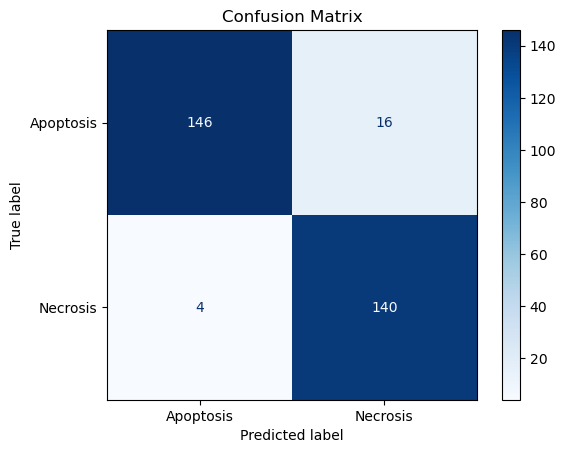

In [129]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model and collect predictions
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set and collect predictions and true labels.
    Args:
        model (torch.nn.Module): The trained model.
        test_loader (DataLoader): The DataLoader for the test set.
    Returns:
        list, list: Lists of true labels and predicted labels.
    """
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for img, label in test_loader:
            img = img.to(device)  # Move images to the appropriate device
            label = label.to(device)  # Move labels to the appropriate device

            # Forward pass
            output = model(img)  # Add batch dimension if needed
            _, predicted = torch.max(output, 1)  # Get the predicted class
            
            # Append true and predicted labels
            true_labels.append(label.item())
            pred_labels.append(predicted.item())

    return true_labels, pred_labels

# Evaluate the model and collect predictions
true_labels, pred_labels = evaluate_model(model.cuda(), test_loader)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])  # Adjust labels if needed

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Apoptosis", "Necrosis"])
disp.plot(cmap="Blues", values_format="d")  # Use a colormap and integer formatting
plt.title("Confusion Matrix")
plt.show()


<h1> GradCAM visualization </h1>

In [ ]:
import torch
from torchvision.models import resnet50
import torch.nn as nn

# Define the fine-tuned ResNet50 model with AdaptiveAvgPool
class FineTunedResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(FineTunedResNet50, self).__init__()
        # Load the pre-trained ResNet50 backbone
        self.backbone = resnet50(pretrained=False)
        
        # Replace the average pooling layer with AdaptiveAvgPool
        self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Replace the fully connected layer for binary classification
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Initialize the model
model = FineTunedResNet50(num_classes=2)


# Load the saved checkpoint
checkpoint_path = r"C:\rkka_Projects\cell_death_v1\0_6\resnet50_variable_input_epoch_4_val_acc_93.46_.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully.")


c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_3496\2069590032.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

Model loaded successfully.


In [80]:
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM with the model and target layer.
        Args:
            model (torch.nn.Module): The neural network model.
            target_layer (torch.nn.Module): The target layer to compute Grad-CAM.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        """
        Register forward and backward hooks on the target layer.
        """
        # Save activations from the forward pass
        self.hook_handles.append(self.target_layer.register_forward_hook(self._save_activations))
        # Save gradients from the backward pass
        self.hook_handles.append(self.target_layer.register_backward_hook(self._save_gradients))

    def _save_activations(self, module, input, output):
        self.activations = output

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __del__(self):
        # Remove hooks when the instance is deleted
        for handle in self.hook_handles:
            handle.remove()

    def generate_cam(self, input_tensor, target_class=None):
        """
        Generate the Grad-CAM heatmap for a given input.
        Args:
            input_tensor (torch.Tensor): The input image tensor (1, C, H, W).
            target_class (int, optional): The target class index. Defaults to the predicted class.
        Returns:
            numpy.ndarray: The Grad-CAM heatmap (H, W).
        """
        # Forward pass
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass for the target class
        self.model.zero_grad()
        target_score = output[0, target_class]
        target_score.backward()

        # Compute Grad-CAM heatmap
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # Global average pooling of gradients
        cam = torch.sum(weights * self.activations, dim=1).squeeze(0)  # Weighted sum of activations
        cam = torch.relu(cam)  # Apply ReLU to remove negative values
        cam = cam / cam.max()  # Normalize to [0, 1]
        return cam.detach().cpu().numpy()


In [101]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Function to preprocess the input image
def preprocess_image(image_path):
    """
    Preprocess the input image to prepare it for the model.
    Args:
        image_path (str): Path to the input image.
    Returns:
        torch.Tensor: Preprocessed image tensor (1, C, H, W).
        numpy.ndarray: Original image for visualization.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize for ResNet
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return input_tensor, np.array(image)

# Function to overlay Grad-CAM heatmap on the original image
def overlay_cam_on_image(image, cam):
    """
    Overlay the Grad-CAM heatmap on the original image.
    Args:
        image (numpy.ndarray): Original image as a NumPy array (H, W, C).
        cam (numpy.ndarray): Grad-CAM heatmap as a NumPy array (H, W).
    Returns:
        numpy.ndarray: Image with Grad-CAM overlay.
    """
    cam_resized = cv2.resize(cam, (image.shape[1], image.shape[0]))  # Resize CAM to match the image size
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(image) / 255
    overlay = overlay / np.max(overlay)  # Normalize to [0, 1]
    return (overlay * 255).astype(np.uint8)


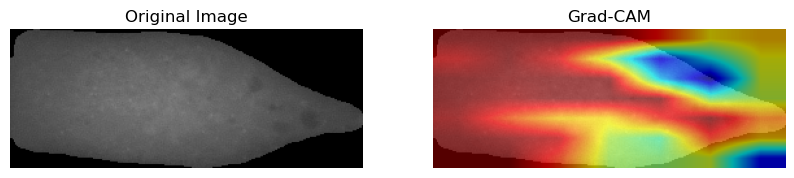

In [100]:
# Path to input image
image_path = r"C:\rkka_Projects\cell_death_v1\Data\pathway\qpi\test\apoptosis\time_00_file_8_label_3.png"

# Preprocess image
input_tensor, original_image = preprocess_image(image_path)

# Target layer for Grad-CAM (last convolutional block)
target_layer = model.backbone.layer4[-1]  # ResNet50 last convolutional layer

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Generate Grad-CAM heatmap
cam = grad_cam.generate_cam(input_tensor, target_class=None)  # Default to predicted class

# Overlay Grad-CAM on the original image
cam_overlay = overlay_cam_on_image(original_image, cam)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cam_overlay)
plt.axis("off")

plt.show()


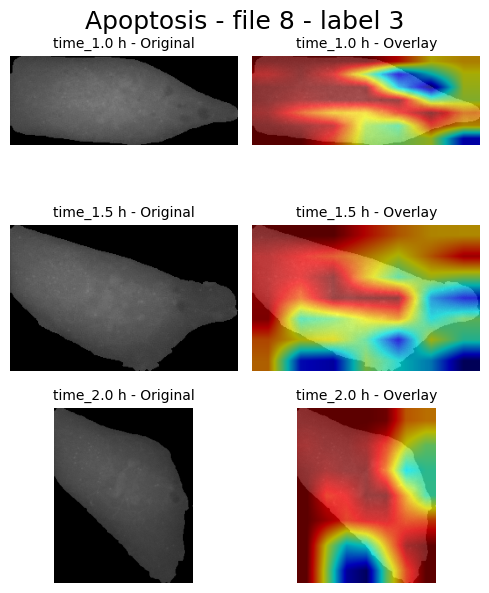

In [133]:
import os
import matplotlib.pyplot as plt

# Function to generate Grad-CAM for a specific file and overlay it
def generate_gradcam_for_file(image_path):
    # Preprocess the image
    input_tensor, original_image = preprocess_image(image_path)

    # Generate Grad-CAM heatmap
    cam = grad_cam.generate_cam(input_tensor, target_class=None)  # Default to predicted class

    # Overlay Grad-CAM on the original image
    cam_overlay = overlay_cam_on_image(original_image, cam)

    return original_image, cam_overlay

# Directory and filename pattern
base_dir = r"C:\rkka_Projects\cell_death_v1\Data\pathway\qpi\test\apoptosis"
filename_pattern = "time_{time:02d}_file_8_label_3.png"

# Create subplots with 7 rows and 2 columns for original and overlay images
fig, axes = plt.subplots(3, 2, figsize=(5, 6))  # 7 rows, 2 columns
axes = axes.reshape(3, 2)  # Reshape to access rows easily

for i in range(3):  # From time_00 to time_06
    time_str = f"time_{(i+2)*0.5} h"
    image_path = os.path.join(base_dir, filename_pattern.format(time=i))

    if os.path.exists(image_path):
        # Generate Grad-CAM visualizations
        original_image, cam_overlay = generate_gradcam_for_file(image_path)

        # Plot the original image in the first column
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f"{time_str} - Original", fontsize=10)
        axes[i, 0].axis("off")
        axes[i, 0].set_aspect('equal')

        # Plot the Grad-CAM overlay in the second column
        axes[i, 1].imshow(cam_overlay)
        axes[i, 1].set_title(f"{time_str} - Overlay", fontsize=10)
        axes[i, 1].axis("off")
        axes[i, 1].set_aspect('equal')
    else:
        # Handle missing files
        axes[i, 0].set_title(f"{time_str} - Missing", fontsize=10, color="red")
        axes[i, 0].axis("off")
        axes[i, 1].set_title(f"{time_str} - Missing", fontsize=10, color="red")
        axes[i, 1].axis("off")

plt.tight_layout()
fig.suptitle('Apoptosis - file 8 - label 3', fontsize=18)
plt.show()